## Classifying Maternal Health Risk using Machine Learning Models

#### Import Statements

In [1]:
# Sci-Kit Learn Library

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# models
from sklearn.linear_model import LogisticRegression
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
# Pandas Library
import pandas as pd

In [3]:
# NumPy Library
import numpy as np

In [4]:
# Matplotlib Library
import matplotlib.pyplot as plt

In [5]:
# Seaborn Library
import seaborn as sns

#### Importing the Dataset

In [6]:
df = pd.read_csv('MaternalRisk.csv')

#### Exploring Dataset

In [7]:
# Descriptive Statistics
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


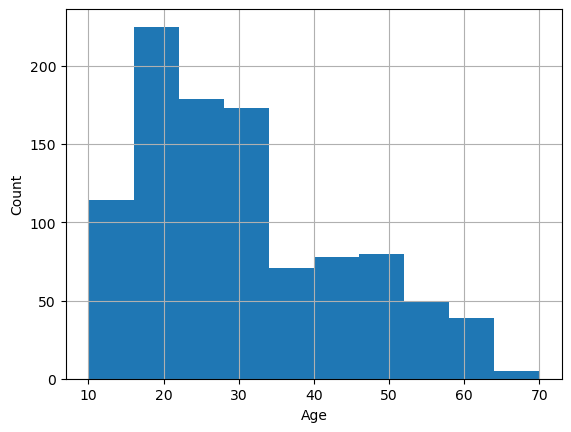

In [8]:
# Age Distribution
df['Age'].hist()
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [9]:
# Risk Class Distribution
class_counts = df['RiskLevel'].value_counts()
print(class_counts)

low risk     406
mid risk     336
high risk    272
Name: RiskLevel, dtype: int64


In [10]:
# Encoding Target Variable, Risk Level to Numerical
risk_mapping = {
    'high risk': 2,
    'mid risk': 1,
    'low risk': 0
}

df['RiskLevel'] = df['RiskLevel'].map(risk_mapping)

In [11]:
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

Normalized the features because they are all on different scales. 

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split the data into a training and test set. The training set contains 80% of the data and the test set contains the other 20%.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=10)

#### Finding Optimal Hyperparameters

In [14]:
# Logistic Regression
lr = LogisticRegression(random_state = 10)

param_grid = {'C': np.logspace(-4,4,10)}

grid_search = GridSearchCV(lr, param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_search.fit(X_scaled, y)

best_c = grid_search.best_params_['C']

print(f"Best C: {best_c:.6f}")

Best C: 0.005995


In [15]:
# Ordinal Logistic Regression

OLR_logit = OrderedModel(y_train, X_train, distr='logit').fit(method='bfgs')
OLR_probit = OrderedModel(y_train, X_train, distr='probit').fit(method='bfgs')

print(f"logit AIC:{OLR_logit.aic}, probit AIC: {OLR_probit.aic}")

Optimization terminated successfully.
         Current function value: 0.793782
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.788990
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
logit AIC:1303.5147450091647, probit AIC: 1295.7423717644056


Since the probit distribution has a lower AIC, that is the distribution I will use.

In [16]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=10)

param_grid = {'max_depth': list(range(1,5))}

grid_search = GridSearchCV(dt, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y)

best_max_depth = grid_search.best_params_['max_depth']

print(f"Best Max Depth: {best_max_depth}")

Best Max Depth: 4


In [17]:
# Random Forest
rf = RandomForestClassifier(random_state = 10)

param_grid = {'max_features': list(range(1, 7))}

grid_search = GridSearchCV(rf, param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_search.fit(X_scaled, y)

best_max_features = grid_search.best_params_['max_features']

print(f"Best # of Max Features: {best_max_features}")

Best # of Max Features: 1


#### Models with Optimized Hyperparameters

In [18]:
# Logistic Regression
LR = LogisticRegression(C=best_c)
LR.fit(X_train, y_train)

LogisticRegression(C=0.005994842503189409)

In [19]:
# Decision Tree
DT = DecisionTreeClassifier(max_depth=best_max_depth)
DT.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4)

In [20]:
# Random Forest
RF = RandomForestClassifier(max_features=best_max_features)
RF.fit(X_train,y_train)

RandomForestClassifier(max_features=1)

#### Model Comparison

In [21]:
# Logistic Regression
LR = LogisticRegression(C=best_c)
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)
LR_accuracy = accuracy_score(y_test, y_pred_LR)
print(f"Logistic Regression Accuracy: {LR_accuracy}")

Logistic Regression Accuracy: 0.5763546798029556


In [22]:
# Ordinal Logistic Regression

OLR = OrderedModel(y_train, X_train, distr='probit')
OLR = OLR.fit(method='bfgs',disp=False)
y_pred_OLR = OLR.predict(X_test)
y_pred_OLR = y_pred_OLR.argmax(axis=1)
OLR_accuracy = accuracy_score(y_test, y_pred_OLR)
print(f"Ordinal Logistic Regression Accuracy: {OLR_accuracy}")

Ordinal Logistic Regression Accuracy: 0.5812807881773399


In [23]:
# Decision Tree
DT = DecisionTreeClassifier(max_depth=best_max_depth)
DT.fit(X_train,y_train)
y_pred_DT = DT.predict(X_test)
DT_accuracy = accuracy_score(y_test, y_pred_DT)
print(f"Decision Tree Accuracy: {DT_accuracy}")

Decision Tree Accuracy: 0.645320197044335


In [24]:
# Random Forest
RF = RandomForestClassifier(max_features=best_max_features)
RF.fit(X_train,y_train)
y_pred_RF = RF.predict(X_test)
RF_accuracy = accuracy_score(y_test, y_pred_RF)
print(f"Random Forest Accuracy: {RF_accuracy}")

Random Forest Accuracy: 0.8325123152709359


#### Feature Importance

In [25]:
# Logistic Regression
coefficients = np.abs(LR.coef_[0]) 
feature_names = list(X.columns)

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

print(coef_df)

       Feature  Coefficient
3           BS     0.289862
4     BodyTemp     0.232868
1   SystolicBP     0.227043
5    HeartRate     0.128113
0          Age     0.094106
2  DiastolicBP     0.091290


In [26]:
# Ordinal Logistic Regression

coefficients = np.abs(OLR.params.iloc[:len(X.columns)]) 
feature_names = list(X.columns)

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

print(coef_df)

        Feature  Coefficient
x4           BS     0.821944
x2   SystolicBP     0.458814
x5     BodyTemp     0.417068
x6    HeartRate     0.213583
x3  DiastolicBP     0.026540
x1          Age     0.000755


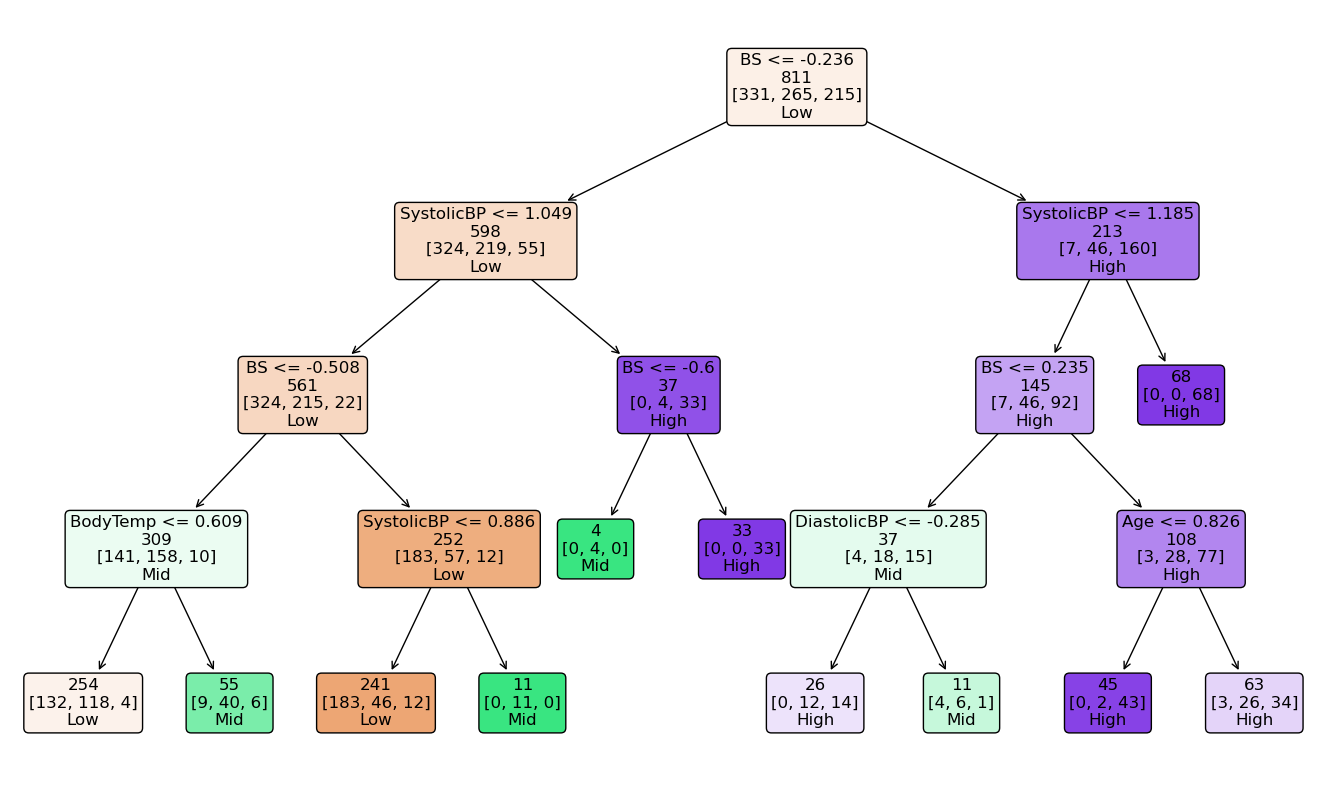

In [27]:
# Decision Tree
plt.figure(figsize=(17, 10))
plot_tree(DT, filled=True, feature_names=X.columns, class_names=["Low", "Mid", "High"], rounded=True, impurity=False, fontsize=12,proportion=False,label='none')
plt.show()

In [28]:
# Decision Tree
feature_names = list(X.columns)
feature_imp = pd.DataFrame( {'importance':DT.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
BS,0.635239
SystolicBP,0.277162
BodyTemp,0.040435
Age,0.035685
DiastolicBP,0.011480
HeartRate,0.000000


In [29]:
# Random Forest
feature_names = list(X.columns)
feature_imp = pd.DataFrame( {'importance':RF.feature_importances_}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
BS,0.358522
Age,0.181122
SystolicBP,0.153453
DiastolicBP,0.142906
HeartRate,0.107797
BodyTemp,0.056199


In [30]:
feature_names

['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

In [31]:
# Ranking
# 1 is most important, 6 is least important (according to the 3 tables above)
data = {
    'Feature': feature_names,
    'Ordinal Logistic Regression': [6, 2, 5, 1, 3, 4],
    'Decision Tree': [4, 2, 5, 1, 3, 6],
    'Random Forest': [2, 3, 4, 1, 6, 5],
}

df = pd.DataFrame(data).set_index('Feature')

In [32]:
df

,Ordinal Logistic Regression,Decision Tree,Random Forest
Feature,,,
Age,6,4,2
SystolicBP,2,2,3
DiastolicBP,5,5,4
BS,1,1,1
BodyTemp,3,3,6
HeartRate,4,6,5


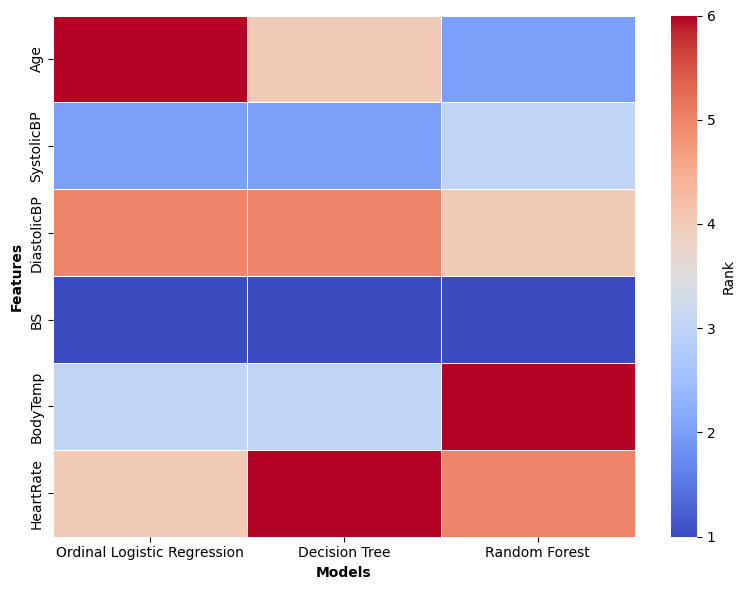

In [33]:
# Heatmap of feature ranking
plt.figure(figsize=(8, 6)) 
sns.heatmap(df, cmap="coolwarm", cbar_kws={'label': 'Rank'}, linewidths=0.5)

plt.ylabel("Features", fontweight='bold')
plt.xlabel("Models", fontweight='bold')
plt.tight_layout()
plt.show()

#### Confusion Matrices

In [34]:
labels = ['Low', 'Mid', 'High']

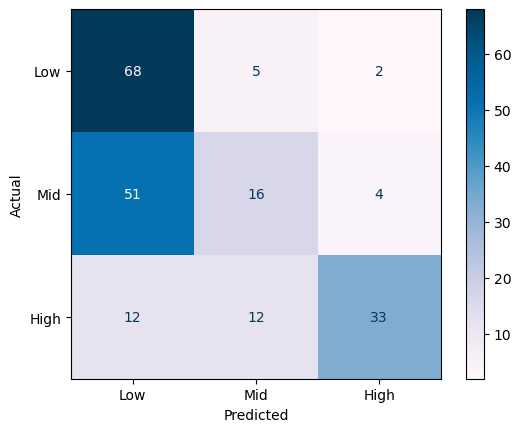

In [35]:
# Logistic Regression
LR_conf_matrix = confusion_matrix(y_test, y_pred_LR)

display = ConfusionMatrixDisplay(confusion_matrix=LR_conf_matrix, display_labels=labels)
display.plot(cmap='PuBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

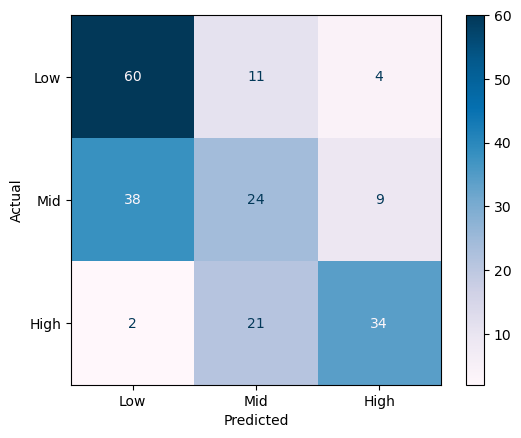

In [36]:
# Ordinal Logistic Regression
OLR_conf_matrix = confusion_matrix(y_test, y_pred_OLR)

display = ConfusionMatrixDisplay(confusion_matrix=OLR_conf_matrix, display_labels=labels)
display.plot(cmap='PuBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

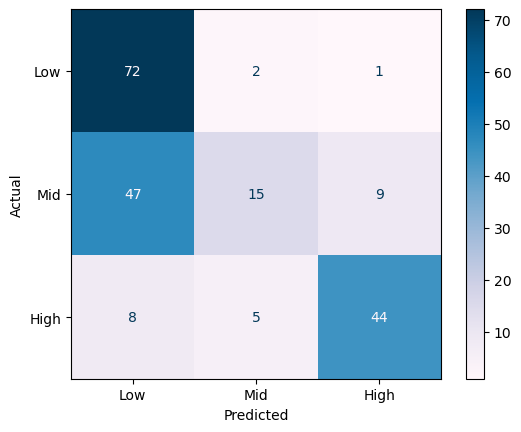

In [37]:
# Decision Tree
DT_conf_matrix = confusion_matrix(y_test, y_pred_DT)

display = ConfusionMatrixDisplay(confusion_matrix=DT_conf_matrix, display_labels=labels)
display.plot(cmap='PuBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

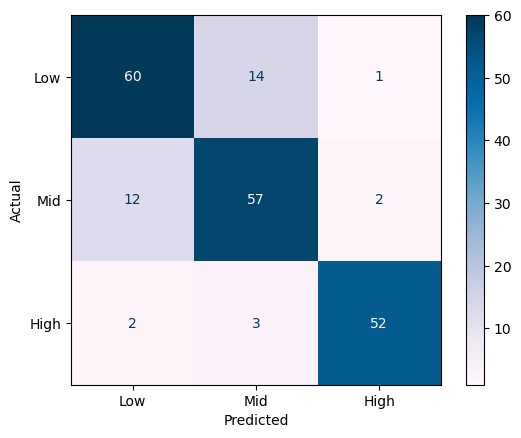

In [38]:
# Random Forest
RF_conf_matrix = confusion_matrix(y_test, y_pred_RF)

display = ConfusionMatrixDisplay(confusion_matrix=RF_conf_matrix, display_labels=labels)
display.plot(cmap='PuBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [41]:
# Aggregated sum of the 3 confusion matrices (OLR, DT, RF)
combined_cm = OLR_conf_matrix + DT_conf_matrix + RF_conf_matrix
print(combined_cm)

[[192  27   6]
 [ 97  96  20]
 [ 12  29 130]]


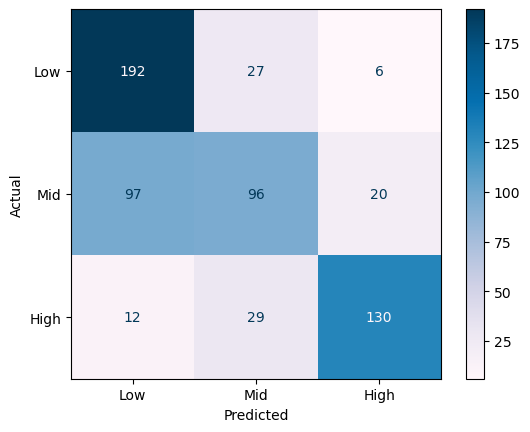

In [40]:
display = ConfusionMatrixDisplay(confusion_matrix=combined_cm, display_labels=labels)
display.plot(cmap='PuBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()